Initial setup requires downloading this repository which will include the correct file structure and files necessary for completing this reverse image search.  

In [ ]:
!git clone https://github.com/pedrojrv/milvus_image_retrieval

Change the directory so that you are in the milvus_image_retrieval main folder.  

Install library packages below before running code.  Starts here. 

In [ ]:
!pip install tensorflow pymilvus==1.0.1 matplotlib pandas pillow

In [ ]:
import os
import sys 
import time
#!pip install mtcnn
#Downloading all the libraries
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
import tensorflow
import random
import numpy
import cv2
import torch
import cv2 as cv
import PIL
from PIL import Image
from keras.preprocessing.image import save_img


Below, we are importing the three main .py files that will help us to execute our image search. Specifically, image_to_vec contains the image resnet50 model and execution.  This reads an image and transfers the data into a numpy array. The Resnet 50 model extracts features from the image data and converts the features into a numpy array.  The image_utilities file is altered to display the number of query image results.  Otherwise, it is left alone. 

In [ ]:
from utilities import image_to_vec
from utilities import milvus_utilities
from utilities import image_utilities

In [ ]:
# Downloading the dataset
!echo "Downloading lFW dataset"
!curl -L -o lfw.tgz http://vis-www.cs.umass.edu/lfw/lfw.tgz
!tar -xzf lfw.tgz
!rm lfw.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  172M  100  172M    0     0  49.5M      0  0:00:03  0:00:03 --:--:-- 49.5M


Below is an approach to the reverse image search problem using Facenet.  We investigated this approach as a way to increase the accuracy. The method uses only the facial data as an input into resnet 50 in order to extract features on a more focused area in the hopes of being more accurate. 

In the below code, we have two functions that were used to perform a method of Facenet in order to identify images more accurately.  The idea is to load an image into a numpy array and crop the image to only show the face of the person within it.  The cropped image is then resized and resnet 50 is used to extract features from it.  

The 4 cells below are only as an example of a way to better improve the results of the image search but is not used in the rest of the reverse image search on this page.  

In [ ]:
#!pip install mtcnn
import mtcnn
detector = mtcnn.MTCNN()

In [ ]:
# Converting the image into numpy array
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing import image
from PIL import Image

def image_numpy(path):
    image1 = image.load_img(path, target_size=(224,224))
    img = image.img_to_array(image1)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return image1, img

def face_numpy(path):
    i = 1
    #directory = str(path)
    img = image.load_img(path, target_size=(224,224))
    pixels = image.img_to_array(img)
    # pixels = np.expand_dims(pixels, axis=0)
    results = detector.detect_faces(pixels)[0] # extract position of the first face

    x1, y1, width, height = results['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    
    img = np.array(Image.fromarray(face.astype(np.uint8)).resize((224, 224))).astype('float32')
    save_img(str(os.path.basename(path)), img)
    return img#np.array([img])

In [ ]:
# Storing the shape of images 
image1, img = image_numpy("lfw/Zoe_Ball/Zoe_Ball_0001.jpg")
print("shape of x: ", img.shape)
print("data type: ", img.dtype)
plt.imshow(image1)

In [ ]:
face_img = face_numpy("lfw/Zoe_Ball/Zoe_Ball_0001.jpg")
print("shape of x: ", face_img.shape)
print("data type: ", face_img.dtype)

Below, we go back to our original method for improving the reverse image search. 

The code below embedding_generator.get_embedding is running resnet 50 on the image path.  We will use this for all of the images in lfw. 

In [ ]:
# we first instantiate our Image Vectorizer class
embedding_generator = image_to_vec.ImgageVectorizer()

In [ ]:
example_vector = embedding_generator.get_embedding("notebook/lfw/Zoe_Ball/Zoe_Ball_0001.jpg")
example_vector

array([0.        , 0.9105351 , 0.02660447, ..., 0.17363709, 0.00696145,
       0.29827017], dtype=float32)

In [ ]:
example_vector.reshape(1, -1).shape

(1, 2048)

In [ ]:
assert example_vector.shape[0] == 2048
example_vector.shape

(2048,)

In [ ]:
image_directory = "notebook/lfw/Zoe_Ball/"
image_extension = ".jpg"

all_embeddings, filepaths = image_to_vec.get_embeddings_from_directory(
    image_directory, extension=image_extension)

In [ ]:
all_embeddings.shape == (10, 2048)

False

In [ ]:
import pandas as pd

The below code will save the dataframe as a csv containing the features discovered by resnet50 for the single image. 

In [ ]:
df_embeddings = pd.DataFrame(all_embeddings)
# append the image_paths to our csv files
df_embeddings['image_path'] = filepaths
# we save the file in the data directory
df_embeddings.to_csv("notebook/lfw/example_embeddings.csv", index=False)

In [ ]:
df_embeddings.head()

0         1         2         3         4    5         6         7  \
0  0.0  0.910535  0.026604  0.657862  0.365509  0.0  0.267089  0.112904   

          8         9  ...      2039      2040      2041      2042     2043  \
0  0.001036  0.169305  ...  0.158124  0.155634  4.118978  0.325755  0.00924   

   2044      2045      2046     2047                               image_path  
0   0.0  0.173637  0.006961  0.29827  notebook/lfw/Zoe_Ball/Zoe_Ball_0001.jpg  

[1 rows x 2049 columns]

The code below will run resnet50 on every image in the lfw dataset. 

In [ ]:
image_directory = "notebook/lfw"
image_extension = ".jpg"

all_embeddings, filepaths = image_to_vec.get_embeddings_from_directory(
    image_directory, extension=image_extension)

In [ ]:
all_embeddings.shape

In [ ]:
df_embeddings = pd.DataFrame(all_embeddings)
# append the image_paths to our csv files
df_embeddings['image_path'] = filepaths
# we save the file in the data directory
df_embeddings.to_csv("lfw/embeddings.csv", index=False)

In [ ]:
imagenet_embeddings = pd.read_csv("notebook/lfw/embeddings.csv")

In [ ]:
# append the data path to the image_path feature
imagenet_embeddings['image_path'] = imagenet_embeddings['image_path'].apply(
    lambda x: os.path.join("notebook/", x))

In [ ]:
# We extract the embedding as a numpy array to upload them to milvus
embedding_vectors = imagenet_embeddings.iloc[:,:-1].values

In [ ]:
#Docker setup and work. 

Using Milvus, a vector search database, we were able to expidite the process of finding similar matches to our query image.  The instructions on how to get Milvus running on your computer are in the link below. 

https://milvus.io/docs/install_standalone-docker.md 

In order to run Milvus, you will need Docker running on your machine. We installed docker desktop for Mac in order to set up Milvus.  

https://docs.docker.com/compose/install/

In [ ]:
!docker ps

CONTAINER ID   IMAGE                                      COMMAND                  CREATED      STATUS         PORTS                      NAMES
79ca55efca56   milvusdb/milvus:1.0.0-cpu-d030521-1ea92e   "/tini -- /var/lib/m…"   4 days ago   Up 3 minutes   0.0.0.0:19530->19530/tcp   locolhost


In [ ]:
import milvus

In [ ]:
from milvus import Milvus, IndexType, MetricType, Status

In [ ]:
# change the HOST and PORT if applicable
_HOST = 'localhost'
_PORT = '19530' 

# We will need the dimension of our vector information to create a collection
_DIM = embedding_vectors.shape[1]  

collection_name = 'lfw_collection'


In [ ]:
milvus = Milvus(_HOST, _PORT)

In [ ]:
# This utility function creates a collection or warns if it already exists
milvus_utilities.create_collection(milvus, collection_name, _DIM, reset=True)

Collection already exists!
Resetting collection...
Succesfully created collection!


In [ ]:
print("ImageNet Embeddings Size: {:.0f}MB".format(embedding_vectors.nbytes * 1e-6))

ImageNet Embeddings Size: 217MB


In [ ]:
inserted_ids = milvus_utilities.insert_embeddings(milvus, collection_name, embedding_vectors, buffer_size=256)

Insertion succesfull.


In [ ]:
status, result = milvus.count_entities(collection_name)

In [ ]:
time.sleep(5) # makes sure the milvus collection updated before evaluating assertion
# we can make sure all our vectors were indeed uploaded by asserttion
# if you get an error try running the cell again, it takes a couple of seconds for the collection to update
status, result = milvus.count_entities(collection_name)
assert embedding_vectors.shape[0] == result

In [ ]:
milvus.flush([collection_name])

Status(code=0, message='OK')

In [ ]:
imagenet_embeddings["milvus_ids"] = inserted_ids

In [ ]:
imagenet_embeddings.to_csv("notebook/imagenet_vectors_w_ids.csv", index=False)

In [ ]:
status = milvus.create_index(collection_name, IndexType.IVF_FLAT, {'nlist': 3000})

In [ ]:
status

Status(code=0, message='Build index successfully!')

Plotting original image:


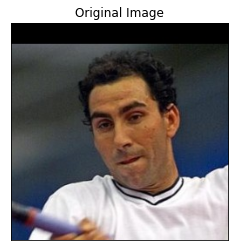

Plotting similar images:


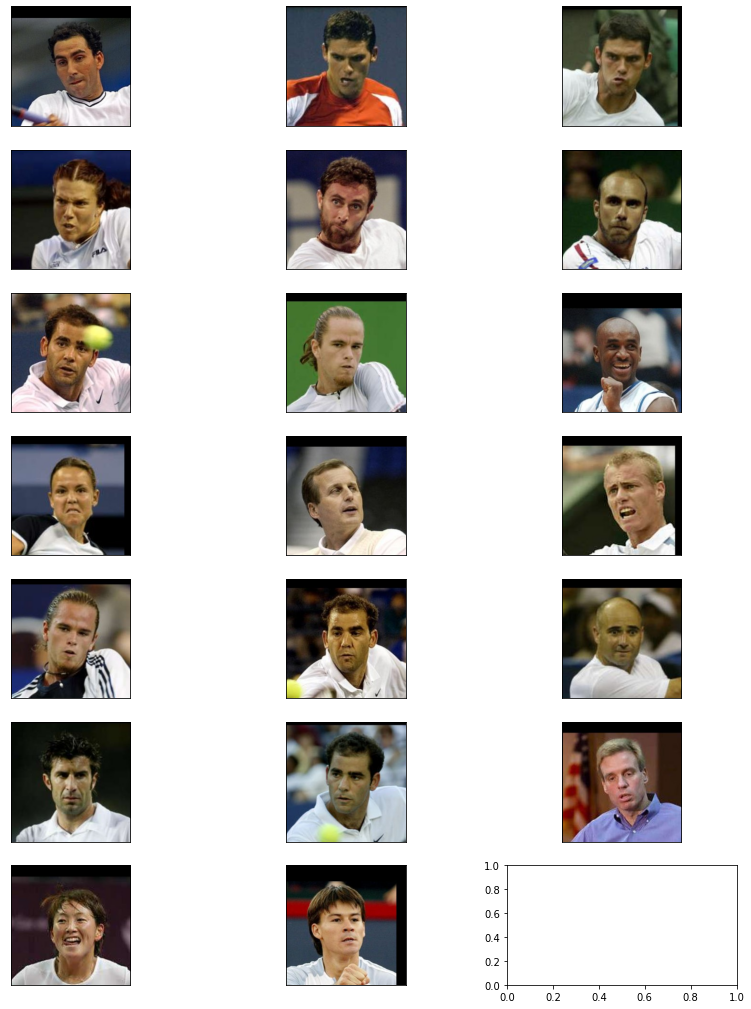

In [ ]:
new_image_path = "notebook/lfw/Albert_Costa/Albert_Costa_0001.jpg"
result_image_name = "albert_costa_results.png"

image_results = image_utilities.get_similar_images(
    milvus, collection_name, new_image_path, plot=True, inventory=imagenet_embeddings, 
    top_k=20, save=True, saving_path=result_image_name)

Plotting original image:


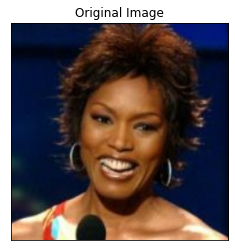

Plotting similar images:


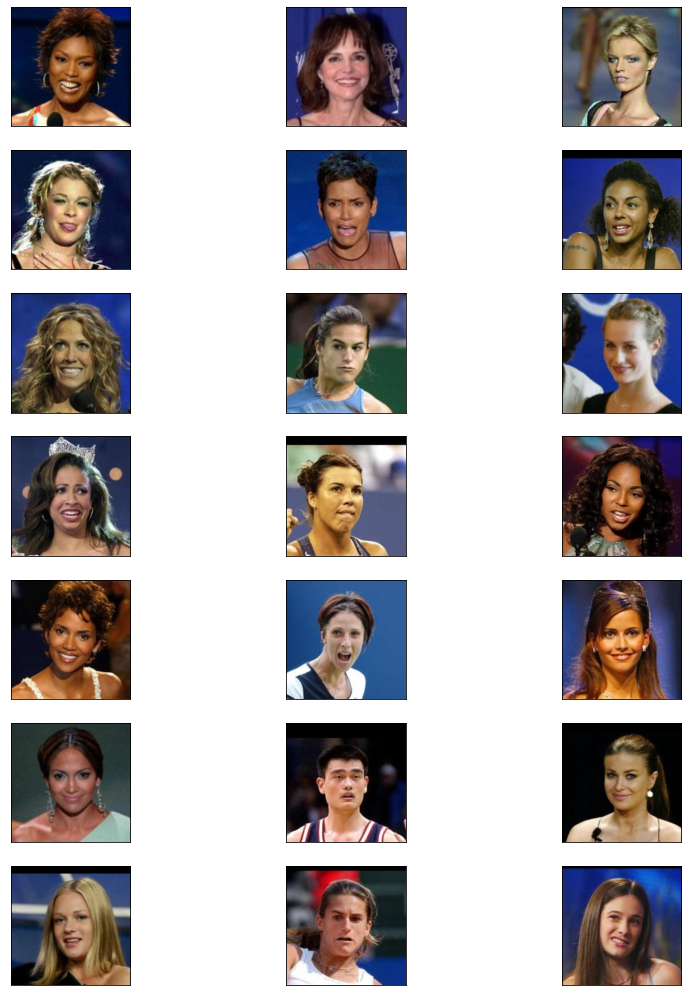

In [ ]:
new_image_path = "notebook/lfw/Angela_Bassett/Angela_Bassett_0001.jpg"
result_image_name = "Angela_Bassett_results.png"

image_results = image_utilities.get_similar_images(
    milvus, collection_name, new_image_path, plot=True, inventory=imagenet_embeddings, 
    top_k=21, save=True, saving_path=result_image_name)

Plotting original image:


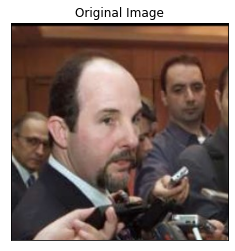

Plotting similar images:


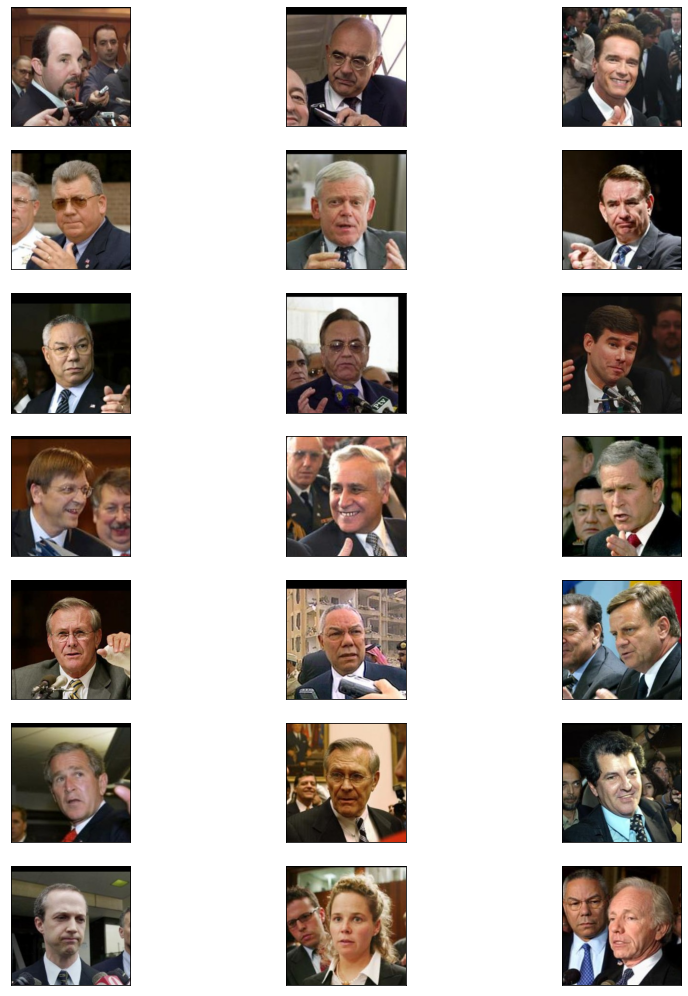

In [ ]:
new_image_path = "notebook/lfw/Arminio_Fraga/Arminio_Fraga_0001.jpg"
result_image_name = "Arminio_Fraga_results.png"

image_results = image_utilities.get_similar_images(
    milvus, collection_name, new_image_path, plot=True, inventory=imagenet_embeddings, 
    top_k=21, save=True, saving_path=result_image_name)

Plotting original image:


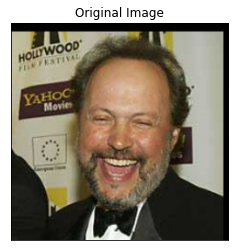

Plotting similar images:


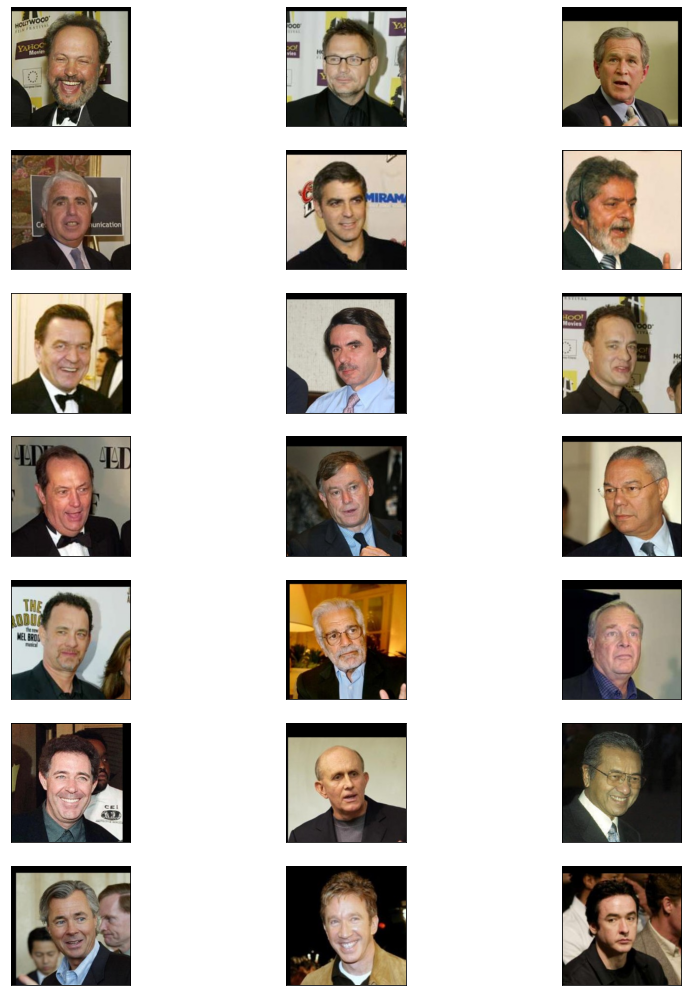

In [ ]:
new_image_path = "notebook/lfw/Billy_Crystal/Billy_Crystal_0001.jpg"
result_image_name = "Billy_Crystal_results.png"

image_results = image_utilities.get_similar_images(
    milvus, collection_name, new_image_path, plot=True, inventory=imagenet_embeddings, 
    top_k=21, save=True, saving_path=result_image_name)

Plotting original image:


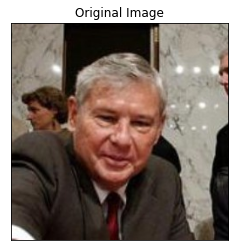

Plotting similar images:


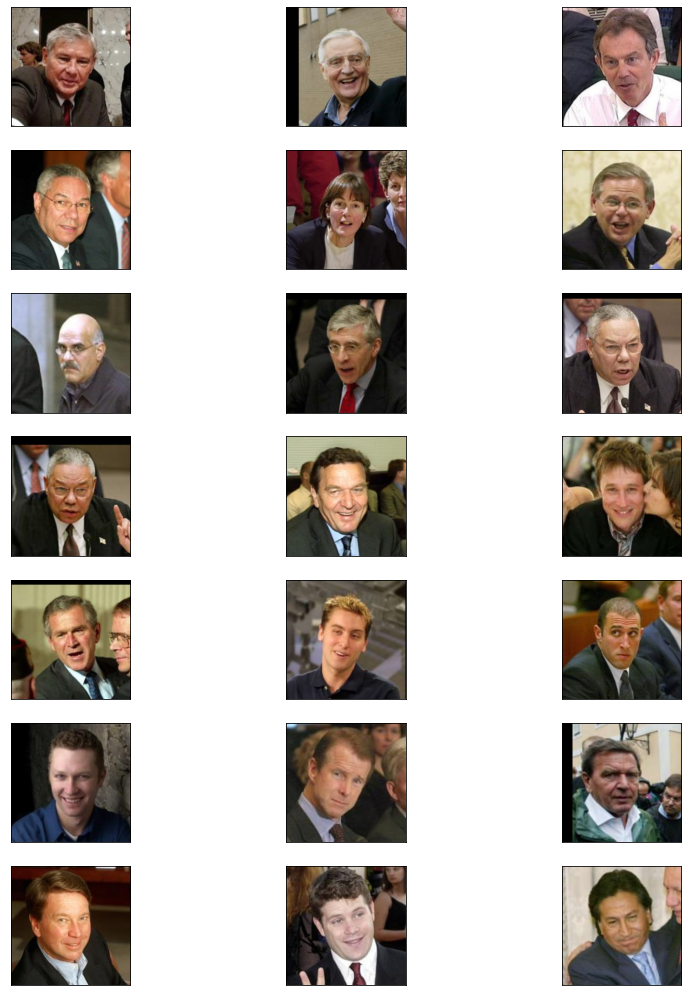

In [ ]:
new_image_path = "notebook/lfw/Bob_Graham/Bob_Graham_0001.jpg"
result_image_name = "Bob_Graham_results.png"

image_results = image_utilities.get_similar_images(
    milvus, collection_name, new_image_path, plot=True, inventory=imagenet_embeddings, 
    top_k=21, save=True, saving_path=result_image_name)

Plotting original image:


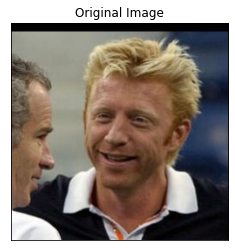

Plotting similar images:


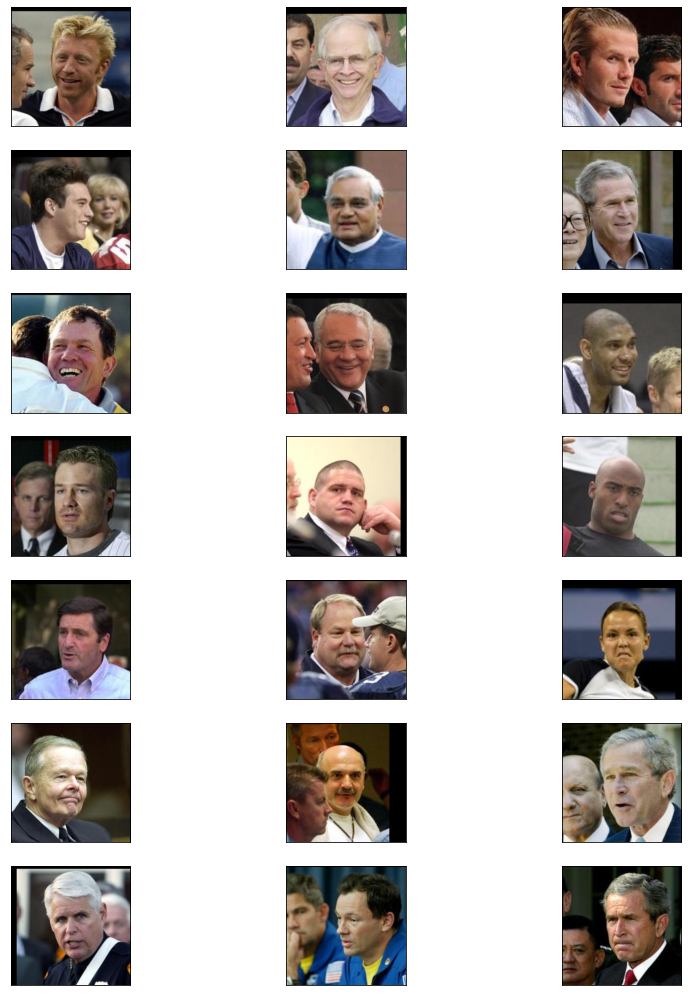

In [ ]:
new_image_path = "notebook/lfw/Boris_Becker/Boris_Becker_0001.jpg"
result_image_name = "Boris_Becker_results.png"

image_results = image_utilities.get_similar_images(
    milvus, collection_name, new_image_path, plot=True, inventory=imagenet_embeddings, 
    top_k=21, save=True, saving_path=result_image_name)

Plotting original image:


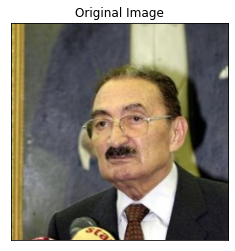

Plotting similar images:


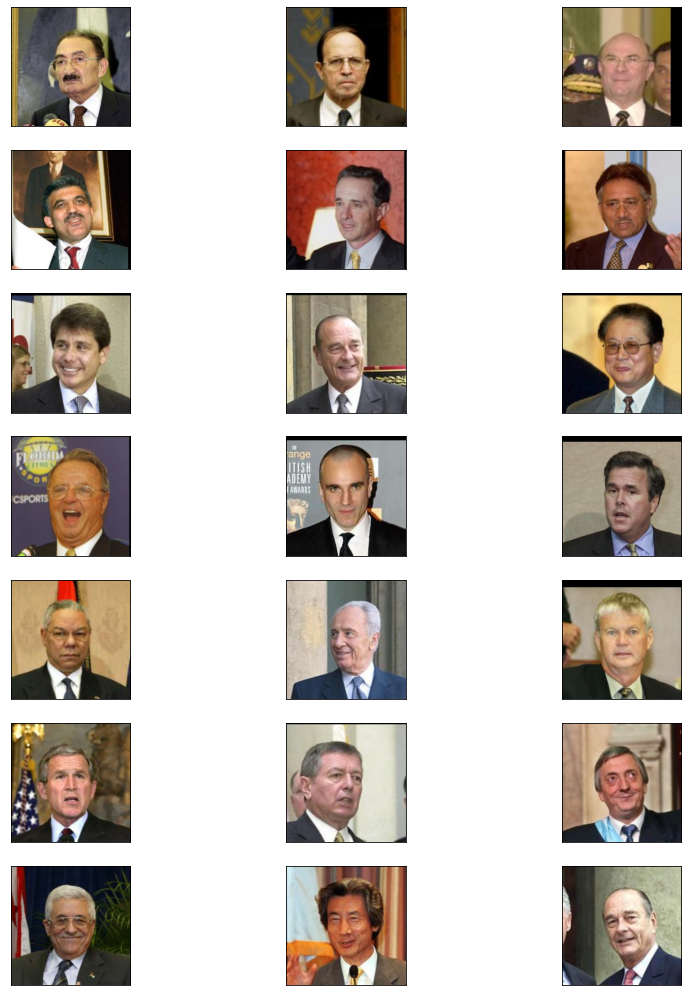

In [ ]:
new_image_path = "notebook/lfw/Bulent_Ecevit/Bulent_Ecevit_0001.jpg"
result_image_name = "Bulent_Ecevit_results.png"

image_results = image_utilities.get_similar_images(
    milvus, collection_name, new_image_path, plot=True, inventory=imagenet_embeddings, 
    top_k=21, save=True, saving_path=result_image_name)

Plotting original image:


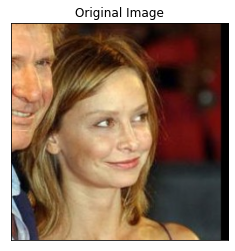

Plotting similar images:


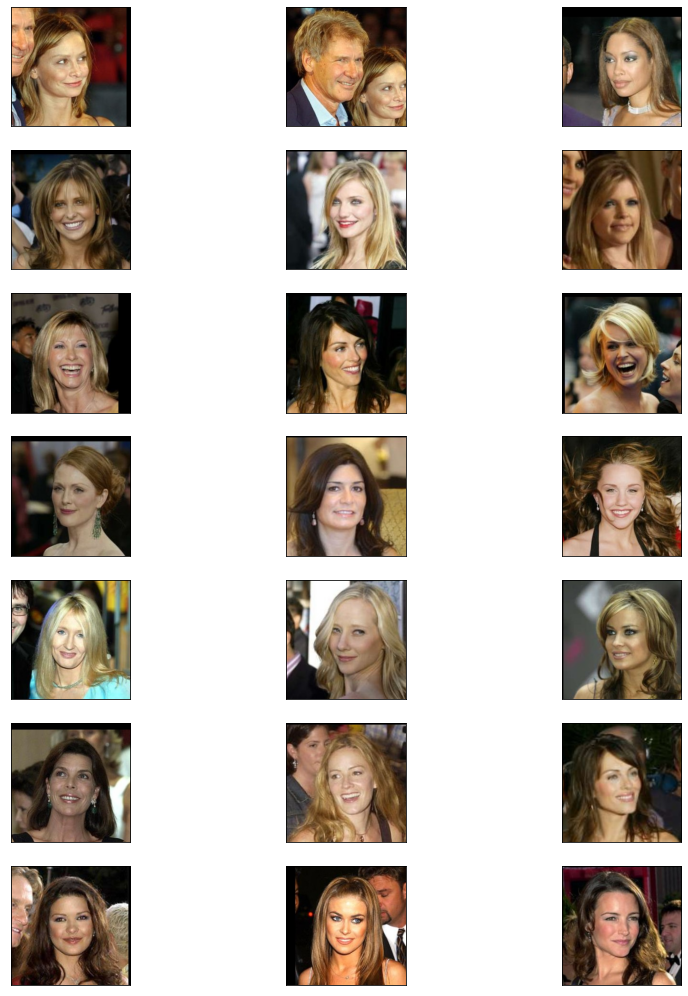

In [ ]:
new_image_path = "notebook/lfw/Calista_Flockhart/Calista_Flockhart_0001.jpg"
result_image_name = "Calista_Flockhart_results.png"

image_results = image_utilities.get_similar_images(
    milvus, collection_name, new_image_path, plot=True, inventory=imagenet_embeddings, 
    top_k=21, save=True, saving_path=result_image_name)

Plotting original image:


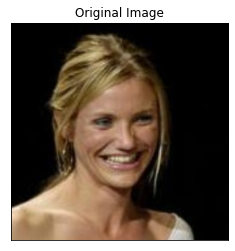

Plotting similar images:


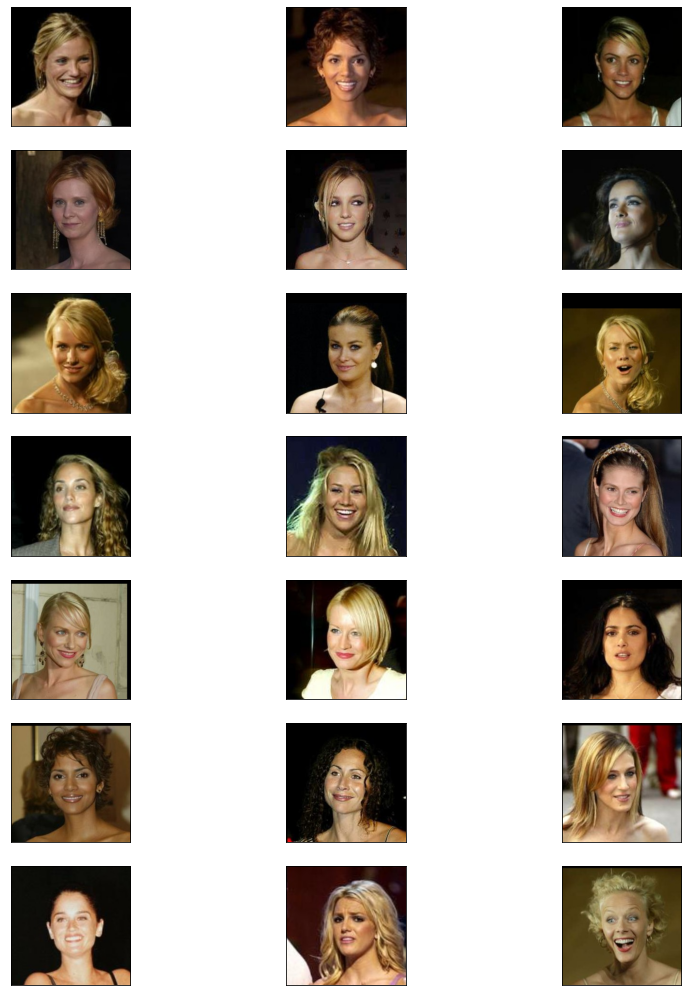

In [ ]:
new_image_path = "notebook/lfw/Cameron_Diaz/Cameron_Diaz_0001.jpg"
result_image_name = "Cameron_Diaz_results.png"

image_results = image_utilities.get_similar_images(
    milvus, collection_name, new_image_path, plot=True, inventory=imagenet_embeddings, 
    top_k=21, save=True, saving_path=result_image_name)

Plotting original image:


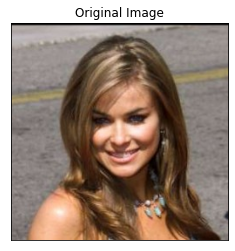

Plotting similar images:


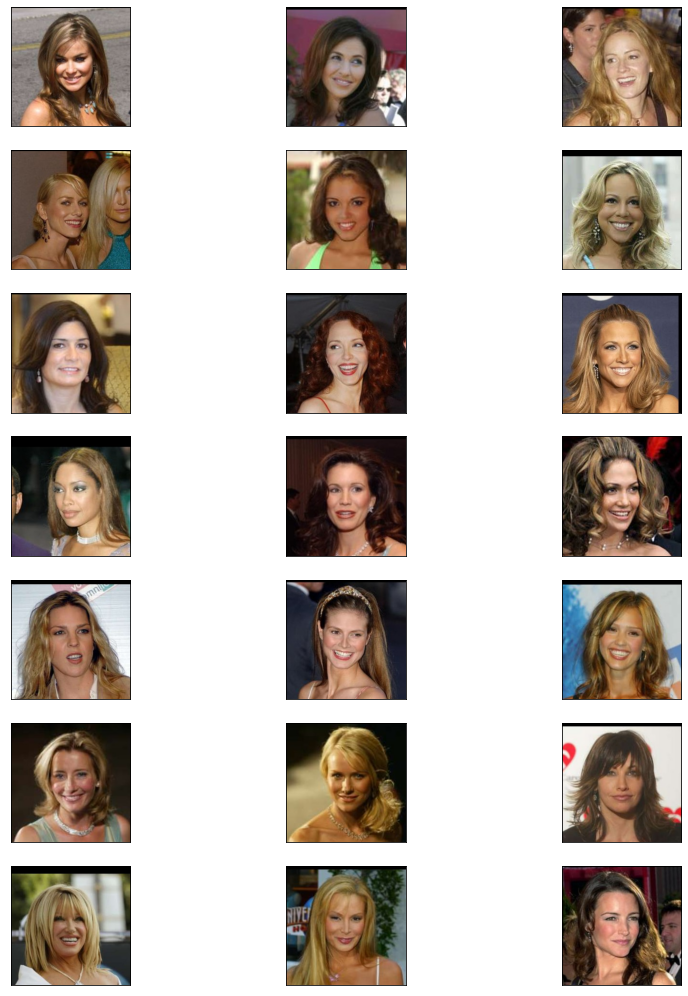

In [ ]:
new_image_path = "notebook/lfw/Carmen_Electra/Carmen_Electra_0001.jpg"
result_image_name = "Carmen_Electra_results.png"

image_results = image_utilities.get_similar_images(
    milvus, collection_name, new_image_path, plot=True, inventory=imagenet_embeddings, 
    top_k=21, save=True, saving_path=result_image_name)